#  Решение задачи регрессии при помощи пакета `torch`. Метрики.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/optim.html
* https://github.com/Lightning-AI/torchmetrics
* https://pytorch.org/docs/stable/generated/torch.no_grad.html
* https://pytorch-lightning.readthedocs.io/en/2.1.2/pytorch/ecosystem/metrics.html#torchmetrics

## Задачи для совместного разбора

In [1]:
from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked
import torch as th

Scalar = TensorType[()]
patch_typeguard()

In [2]:
th.cuda.is_available()

True

1\. Используя реализацию из `torch.nn`, решите задачу регрессии. Для расчета градиентов воспользуйтесь возможностями по автоматическому дифференцированию `torch`. В качестве функции потерь используйте собственную реализацию MSE. Для настройки весов реализуйте пакетный градиентный спуск с использованием `torch.optim.SGD`.

In [3]:
from sklearn.datasets import make_regression
import torch as th

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y)

In [4]:
import torch.nn as nn

class SyntRegressionModel(nn.Module):
    def __init__(self, n_inputs: int, n_hidden: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(in_features=n_inputs, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, X: th.Tensor) -> th.Tensor:
        out = self.fc1(X)
        out = self.relu(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [5]:
model = SyntRegressionModel(n_inputs=4, n_hidden=2)
# y_pred = model.forward(X)
y_pred = model(X)

In [6]:
model.fc1.weight

Parameter containing:
tensor([[ 0.4889, -0.3453, -0.3268,  0.3047],
        [-0.4882,  0.4616, -0.1368,  0.3310]], requires_grad=True)

In [7]:
y_pred.shape

torch.Size([100, 1])

In [8]:
n_inputs = 4
n_hidden = 1
model = nn.Sequential(
    nn.Linear(in_features=n_inputs, out_features=n_hidden),
    nn.ReLU(),
    nn.Linear(in_features=n_hidden, out_features=1),
)

In [9]:
y_pred = model(X)

In [10]:
criterion = nn.MSELoss()

loss = criterion(y_pred.flatten(), y)
loss

tensor(9590.1328, grad_fn=<MseLossBackward0>)

In [11]:
loss.backward()

In [12]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [13]:
optimizer.step()
optimizer.zero_grad()

In [14]:
n_inputs = 4
n_hidden = 1

model = nn.Sequential(
    nn.Linear(in_features=n_inputs, out_features=n_hidden),
    nn.ReLU(),
    nn.Linear(in_features=n_hidden, out_features=1),
)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for _ in range(100):
    # forward pass
    y_pred = model(X)
    loss = criterion(y_pred.flatten(), y)

    # backprop
    loss.backward()

    # gradient descend
    optimizer.step()
    optimizer.zero_grad()

In [15]:
loss

tensor(10630.7246, grad_fn=<MseLossBackward0>)

In [16]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

n_inputs = 4
n_hidden = 1

model = nn.Sequential(
    nn.Linear(in_features=n_inputs, out_features=1),
    # nn.ReLU(),
    # nn.Linear(in_features=n_hidden, out_features=1),
)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

epoch_losses = []
for epoch in range(100):
    epoch_loss = 0
    for X_batch, y_batch in loader:
        # forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred.flatten(), y_batch)
        epoch_loss += loss
        # backprop
        loss.backward()

        # gradient descend
        optimizer.step()
        optimizer.zero_grad()
    
    if epoch % 10 == 0:
        epoch_loss = epoch_loss / len(loader)
        epoch_losses.append( epoch_loss.item())
        print('epoch:', epoch, '; loss: ', epoch_loss.item())

epoch: 0 ; loss:  8647.5029296875
epoch: 10 ; loss:  2239.624267578125
epoch: 20 ; loss:  554.2648315429688
epoch: 30 ; loss:  172.13619995117188
epoch: 40 ; loss:  45.80744552612305
epoch: 50 ; loss:  14.570918083190918
epoch: 60 ; loss:  4.559893608093262
epoch: 70 ; loss:  1.7209657430648804
epoch: 80 ; loss:  0.5388368368148804
epoch: 90 ; loss:  0.16046270728111267


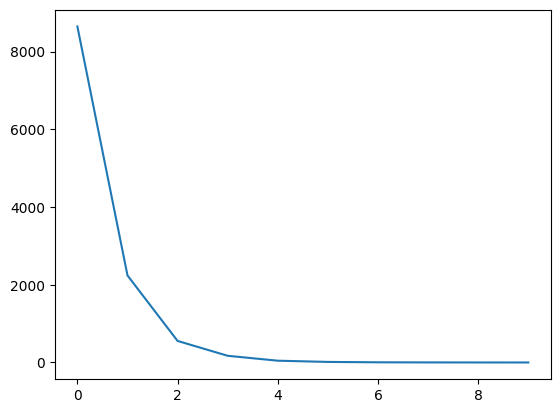

In [17]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.show()

In [18]:
def train(model, dataset, loader, n_epochs, criterion, optimizer, print_every):
    model.train()
    pass

In [19]:
@th.no_grad()
def eval(model):
    model.eval()

In [20]:
with th.no_grad():
    y_pred = model(X)
    print(y_pred.flatten())

tensor([-142.2168,   -3.9785,   -0.3392,  -33.5017,   26.5062,  -22.1182,
          98.1429,   73.1937,  124.3028,  -13.0366, -129.9139,    7.0731,
        -129.7995,  -40.5906,  219.9613, -133.8345,    0.6310,  -55.1563,
         -65.0387,   42.2839, -146.0188,  -67.8537,  -34.7346,  -82.4544,
          52.6168, -175.1765,  -37.6238, -104.9193, -142.3062,  140.4411,
         -35.0313,   10.7325,   95.4505, -158.3831,   -8.0138,   79.6661,
        -105.6934, -165.9799,  -11.9660,    4.2220,   38.4743,   30.6233,
         -90.5628,  156.5878,  132.5911,   66.0101,    9.4624,  104.9791,
          61.5070,  -77.7610,    9.0246,   59.5942,   75.5709,  -35.1896,
          20.3395,   43.5318,   32.5106,    7.2419,   -4.4764,   94.1771,
         -81.7996,   51.3412,   65.9773,   38.4210,  137.2488,  -74.6098,
         -69.1052,    8.5033, -130.0788, -107.8757,  121.4725,    7.8872,
        -140.5761,  -81.1915,   84.9510,   98.3384,   30.2744,  102.7630,
        -117.2288, -100.1736,  -41.016

In [21]:
with th.no_grad():
  y_pred = model(X)

In [22]:
from sklearn.metrics import r2_score

In [23]:
r2_score(y, y_pred.flatten())

0.9999937284403685

In [24]:
import torchmetrics as M

In [25]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

n_inputs = 4
n_hidden = 1

model = nn.Sequential(
    nn.Linear(in_features=n_inputs, out_features=1),
    # nn.ReLU(),
    # nn.Linear(in_features=n_hidden, out_features=1),
)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

epoch_losses = []
for epoch in range(100):
    epoch_loss = 0
    r2_metric = M.R2Score()
    for X_batch, y_batch in loader:
        # forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred.flatten(), y_batch)
        epoch_loss += loss
        r2_metric.update(y_pred.flatten(), y_batch)
        # backprop
        loss.backward()

        # gradient descend
        optimizer.step()
        optimizer.zero_grad()
    
    if epoch % 10 == 0:
        epoch_loss = epoch_loss / len(loader)
        epoch_losses.append( epoch_loss.item())
        r2_epoch = r2_metric.compute()
        print('epoch:', epoch, '| loss:', epoch_loss.item(), '| r2:', r2_epoch.item())

epoch: 0 | loss: 8771.0087890625 | r2: 0.044921278953552246
epoch: 10 | loss: 2180.20751953125 | r2: 0.7560821771621704
epoch: 20 | loss: 654.6030883789062 | r2: 0.9335705637931824
epoch: 30 | loss: 160.26075744628906 | r2: 0.9817810654640198
epoch: 40 | loss: 50.879329681396484 | r2: 0.9947081804275513
epoch: 50 | loss: 14.22844409942627 | r2: 0.9984039068222046
epoch: 60 | loss: 4.93473482131958 | r2: 0.9994974732398987
epoch: 70 | loss: 1.4449739456176758 | r2: 0.9998359084129333
epoch: 80 | loss: 0.4609851837158203 | r2: 0.9999470114707947
epoch: 90 | loss: 0.17469988763332367 | r2: 0.9999822378158569


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Используя реализацию полносвязного слоя из `torch.nn` решите задачу регрессии. В качестве функции потерь используйте реализацию MSE из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`. Для создания модели опишите класс `SineModel`.

Предлагаемая архитектура нейронной сети:
1. Полносвязный слой с 100 нейронами
2. Активация ReLU
3. Полносвязный слой с 1 нейроном

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).

Выведите график изменения значения функции потерь в процессе обучения. Логику расчета значения функции потерь на уровне эпохи реализуйте самостоятельно.

- [ ] Проверено на семинаре

In [26]:
import torch.optim as optim
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

In [28]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=20, shuffle=True)

In [29]:
class SineModel(nn.Module):
    def __init__(self, n_features: int, n_hidden: int, n_out: int) -> None:
        super(SineModel, self).__init__()
        self.fc1 = nn.Linear(in_features=n_features, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=n_out)
        self.relu = nn.ReLU()

    def forward(self, X: TensorType["batch", "n_features"]) -> TensorType["batch", 1]:
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [30]:
model = SineModel(1, 100, 1)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [31]:
def train(model, dataset, loader, n_epochs, criterion, optimizer, save_epochs, print_every=1000):
    saved_loss = {}
    saved_predictions = {}
    for epoch in range(n_epochs):
        loss_arr = []
        for X_batch, y_batch in loader:
            model.train()
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            loss_arr.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch % 50 == 0:
            saved_loss[epoch] = np.mean(loss_arr)
        
        if epoch % print_every == 0:
            print(f'Epoch:{epoch:^6}| Loss: {np.mean(loss_arr):.4f}')
        
        if epoch in save_epochs:
            with th.no_grad():
                y_pred = model(dataset[:][0])
                if y_pred.device.type != 'cpu':
                    y_pred = y_pred.cpu()
                saved_predictions[epoch] = y_pred.numpy().flatten()
    
    return saved_loss, saved_predictions

In [32]:
def plot(X, y, save_epochs, saved_predictions, cols=2):
    X_np = X.numpy().flatten()
    y_np = y.numpy().flatten()
    rows = (len(save_epochs) + 1) // cols

    plt.figure(figsize=(15, rows * 4))
    plt.suptitle('Предсказания модели на различных эпохах', fontsize=20)

    for idx, epoch in enumerate(save_epochs):
        plt.subplot(rows, cols, idx + 1)
        y_pred_np = saved_predictions[epoch]
        
        ix = np.argsort(X_np)
        sns.scatterplot(x=X_np, y=y_np, label='Данные', s=60, edgecolor='w', alpha=0.7)
        sns.scatterplot(x=X_np, y=y_pred_np, color='red', label='Предсказание модели', s=60, edgecolor='w', alpha=0.7)
        sns.lineplot(x=X_np[ix], y=y_pred_np[ix], color='black', linestyle='--')
        
        plt.xlabel('X', fontsize=12)
        plt.ylabel('y', fontsize=12)
        plt.title(f'Epoch {epoch}')
        plt.legend()

    plt.tight_layout()
    plt.show()

def plot_loss(saved_loss, title='Loss/Epoch'):
    plt.title(title)
    sns.lineplot(x=saved_loss.keys(), y=saved_loss.values(), color='black', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [33]:
save_epochs = [0, 100, 250, 500, 1000, 2500, 4950, 7950]
saved_loss, saved_predictions = train(model, dataset, loader, 8001, criterion, optimizer, save_epochs)

Epoch:  0   | Loss: 0.5027
Epoch: 1000 | Loss: 0.0486
Epoch: 2000 | Loss: 0.0089
Epoch: 3000 | Loss: 0.0059
Epoch: 4000 | Loss: 0.0039
Epoch: 5000 | Loss: 0.0032
Epoch: 6000 | Loss: 0.0026
Epoch: 7000 | Loss: 0.0025
Epoch: 8000 | Loss: 0.0025


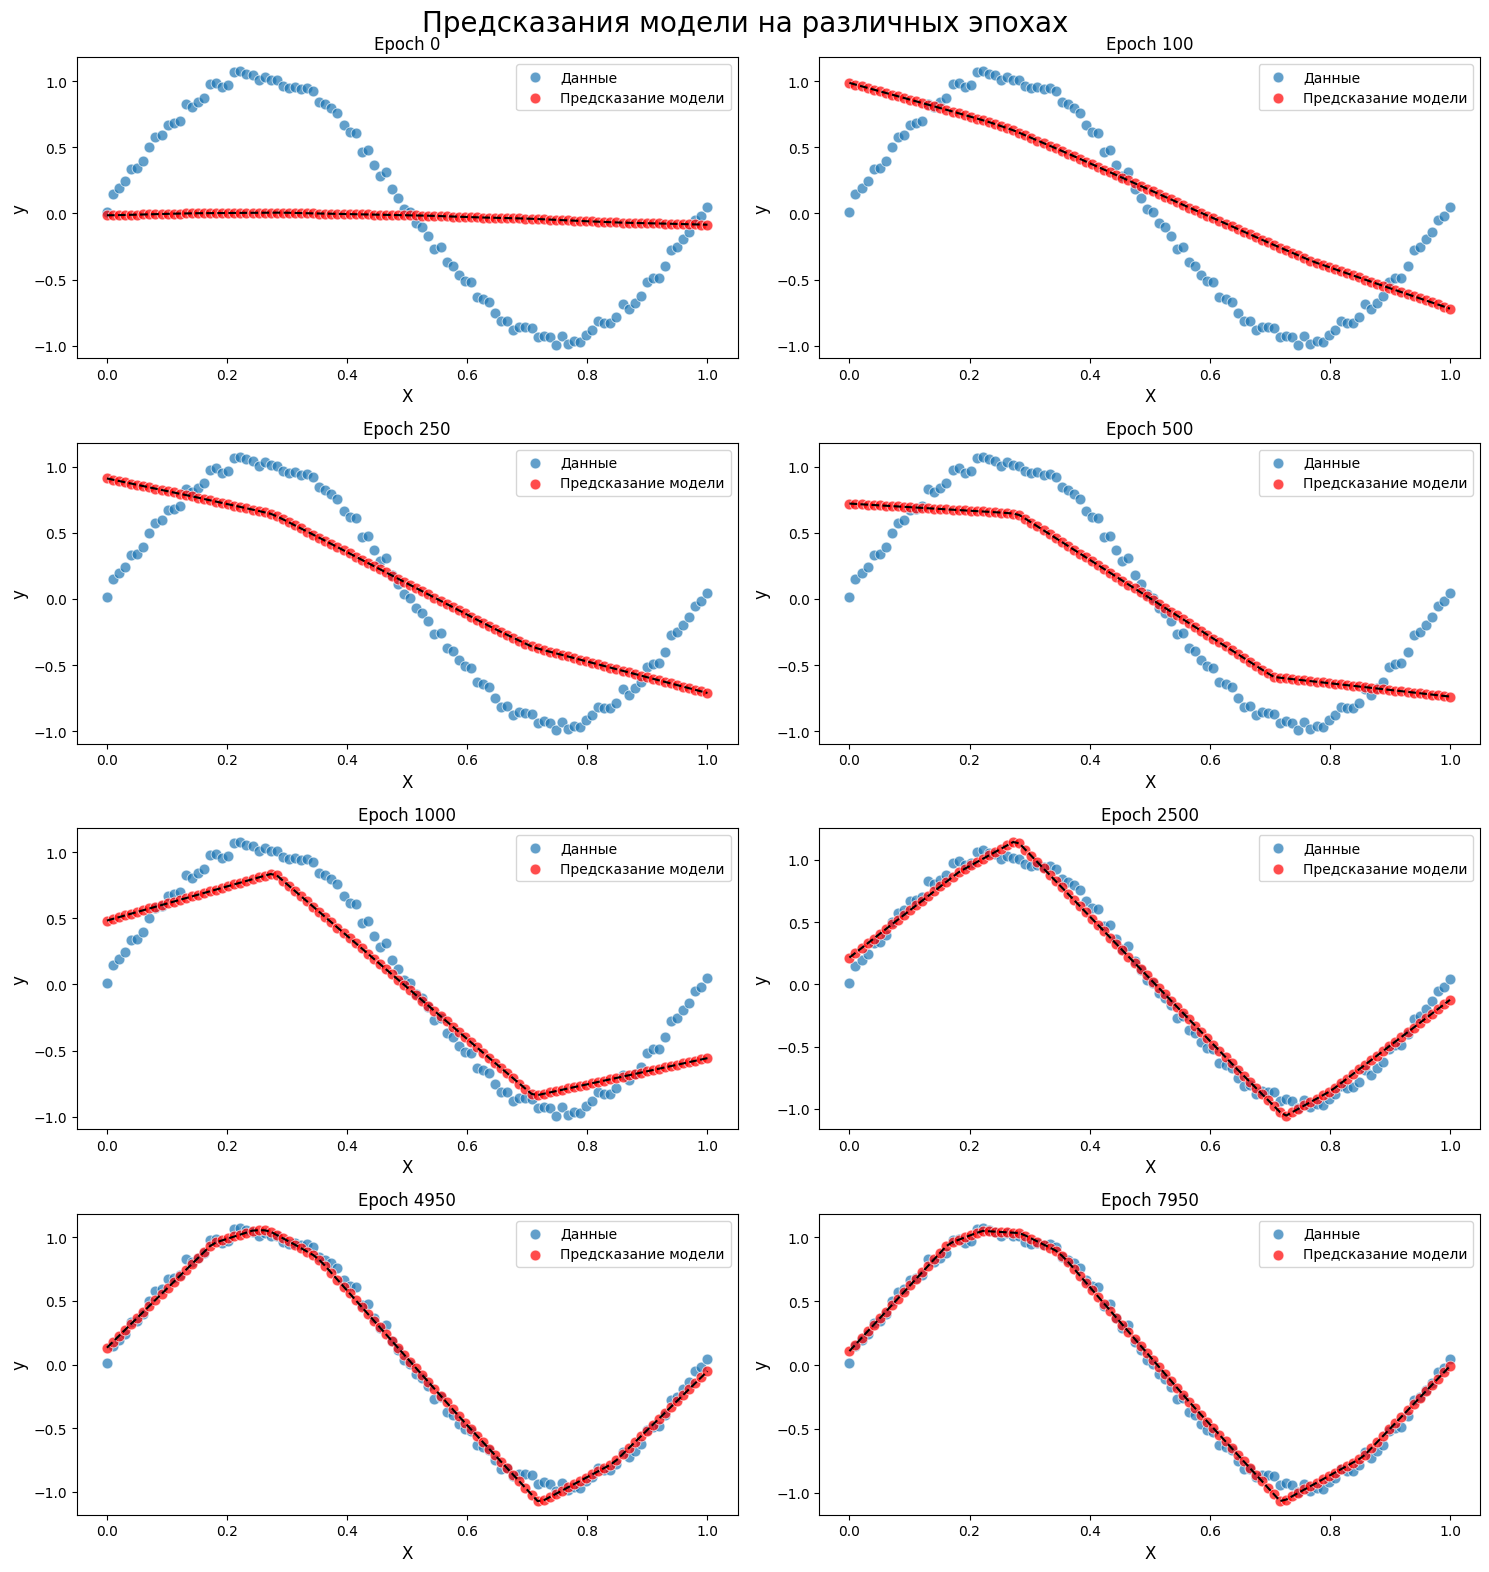

In [34]:
plot(X, y, save_epochs, saved_predictions)

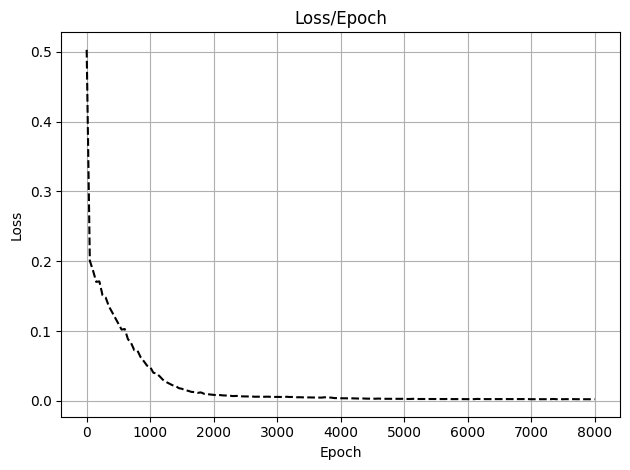

In [35]:
plot_loss(saved_loss)

<p class="task" id="2"></p>

2\. Повторите решение задачи 1, изменив модель. Для создания модели создайте объект класса `nn.Sequential`.

Предлагаемая архитектура нейронной сети:
1. Полносвязный слой с 50 нейронами
2. Активация Tanh
3. Полносвязный слой с 1 нейроном

- [ ] Проверено на семинаре

In [36]:
X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

In [37]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=20, shuffle=True)

In [38]:
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.Tanh(),
    nn.Linear(50, 1),
)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [39]:
saved_loss, saved_predictions = train(model, dataset, loader, 8001, criterion, optimizer, save_epochs)

Epoch:  0   | Loss: 0.5697
Epoch: 1000 | Loss: 0.1934
Epoch: 2000 | Loss: 0.1854
Epoch: 3000 | Loss: 0.1240
Epoch: 4000 | Loss: 0.0125
Epoch: 5000 | Loss: 0.0045
Epoch: 6000 | Loss: 0.0041
Epoch: 7000 | Loss: 0.0038
Epoch: 8000 | Loss: 0.0035


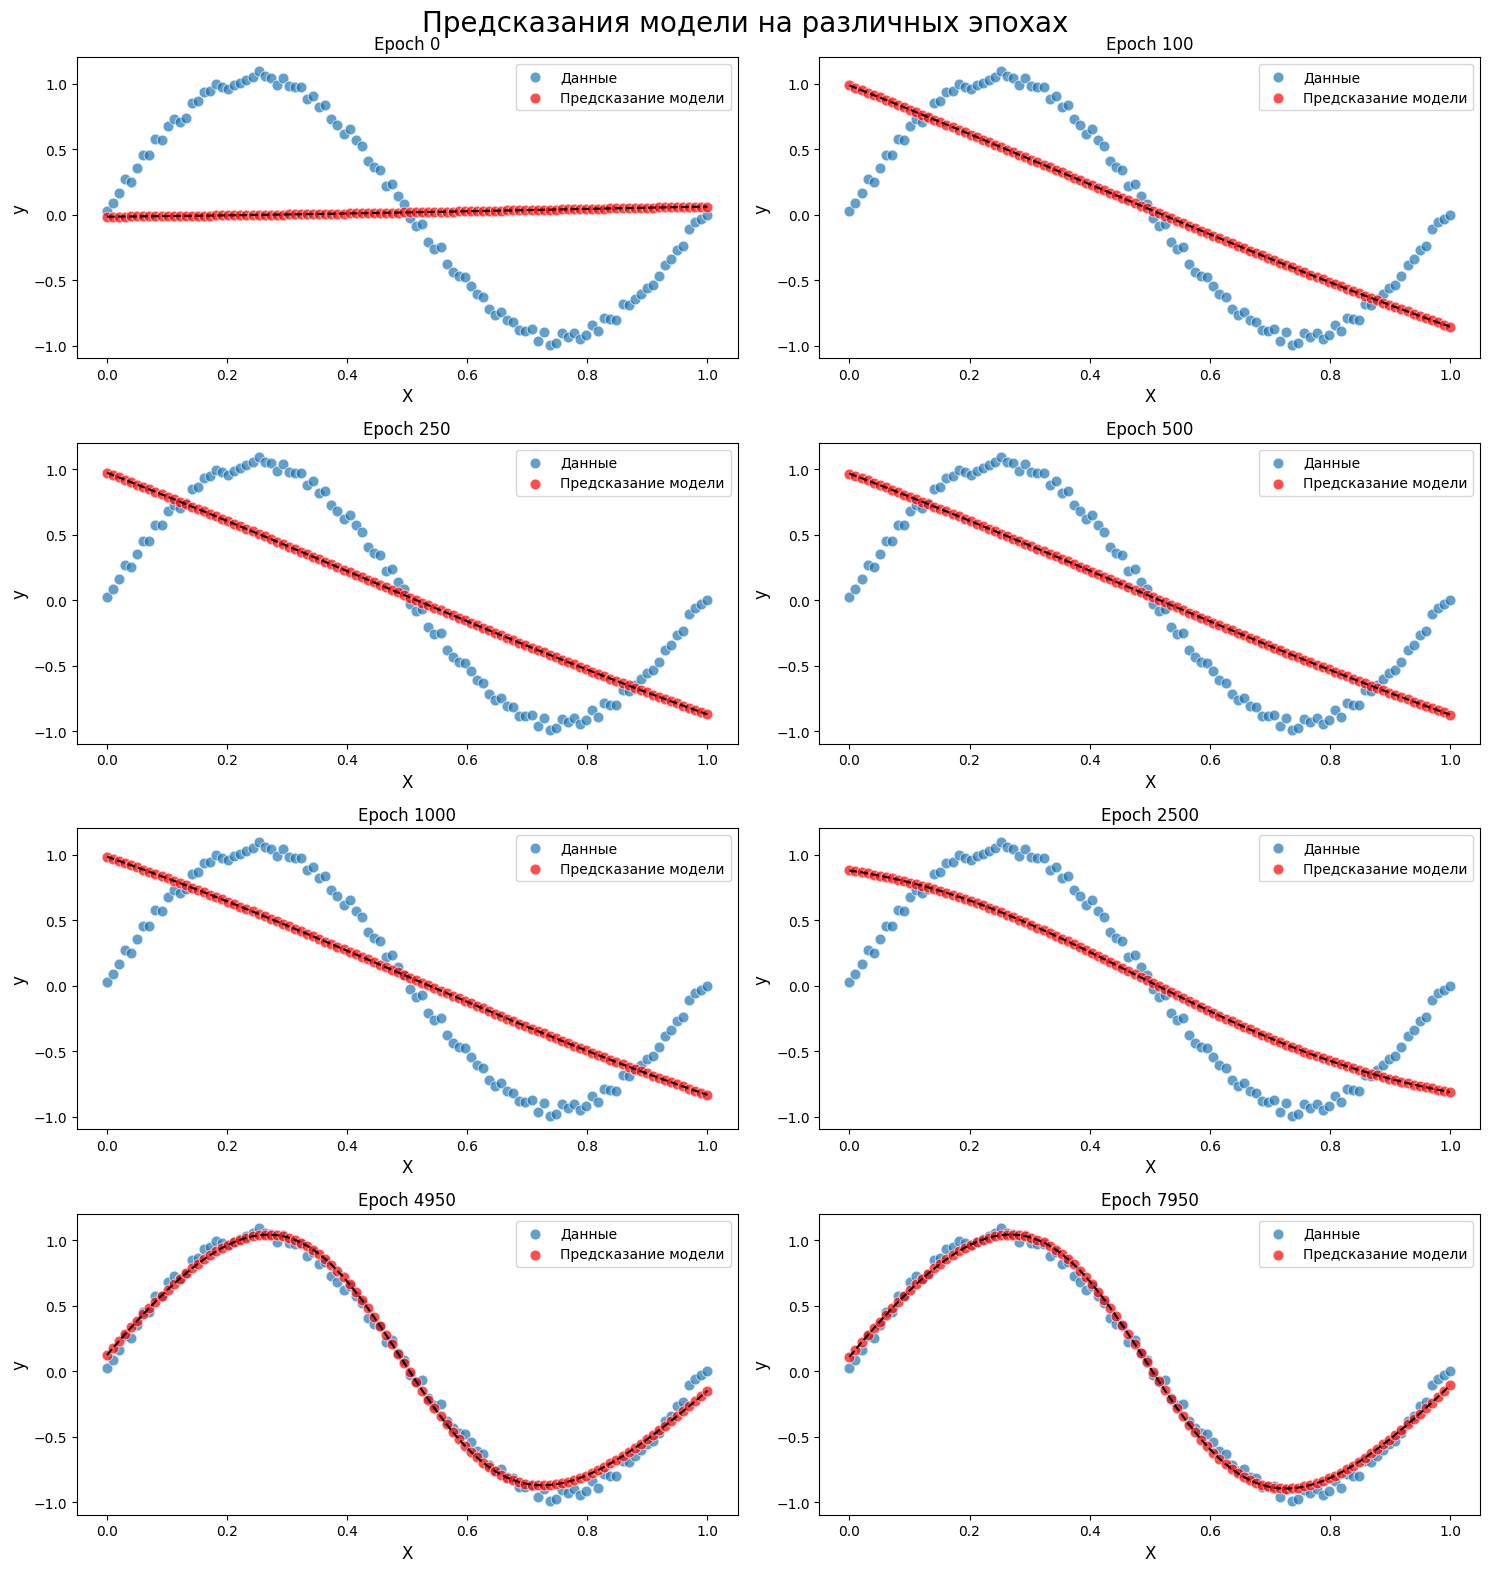

In [40]:
plot(X, y, save_epochs, saved_predictions)

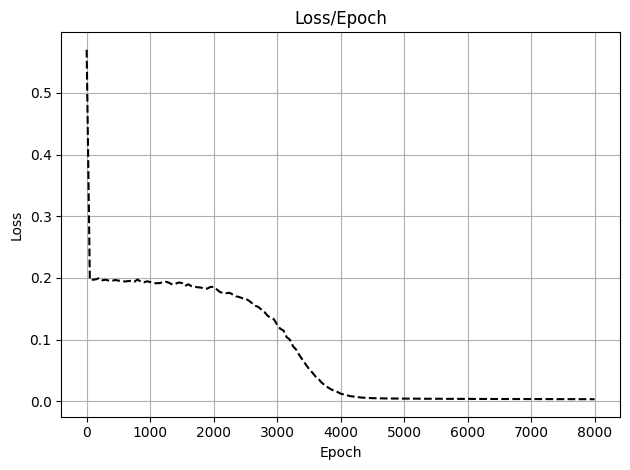

In [41]:
plot_loss(saved_loss)

<p class="task" id="3"></p>

3\. Используя реализацию полносвязного слоя из `torch.nn`, решите задачу регрессии. В качестве функции потерь используйте реализацию MSE из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`. Перенесите вычисления на GPU и сравните время обучения с и без использования GPU. Решение должно корректно работать в случае отсутствия GPU без дополнительных изменений в коде.

- [ ] Проверено на семинаре

In [42]:
from sklearn.datasets import make_regression
import torch as th

X, y, coef = make_regression(
    n_samples=10000,
    n_features=10,
    n_informative=6,
    coef=True,
    bias=0.5,
    random_state=42
)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

In [43]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=2500, shuffle=True)

In [44]:
model = nn.Sequential(
    nn.Linear(10, 50),
    nn.Tanh(),
    nn.Linear(50, 1),
).to('cpu')
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [45]:
print('Запуск с CPU:')
%timeit -n 1 -r 1 saved_loss, saved_predictions = train(model, dataset, loader, 2501, criterion, optimizer, save_epochs, print_every=500)

Запуск с CPU:
Epoch:  0   | Loss: 14667.8185
Epoch: 500  | Loss: 3.1871
Epoch: 1000 | Loss: 0.8527
Epoch: 1500 | Loss: 0.2782
Epoch: 2000 | Loss: 0.2015
Epoch: 2500 | Loss: 0.8088
1min 41s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


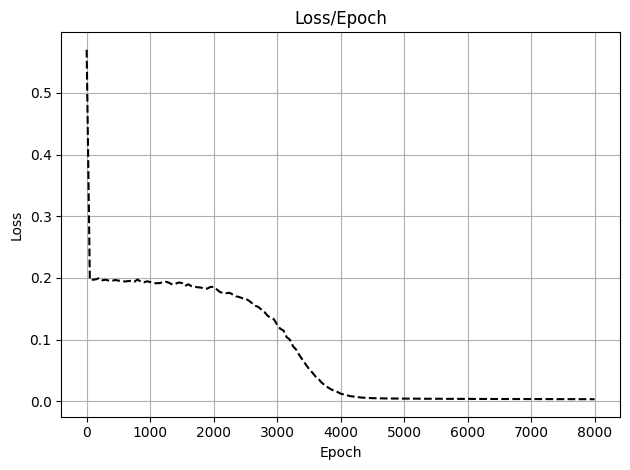

In [46]:
plot_loss(saved_loss)

In [47]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device, th.cuda.device_count()

device(type='cuda')

In [48]:
model = nn.Sequential(
    nn.Linear(10, 50),
    nn.Tanh(),
    nn.Linear(50, 1),
).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss().to(device)

In [49]:
dataset = TensorDataset(X.to(device), y.to(device))
loader = DataLoader(dataset, batch_size=2500, shuffle=True)

In [50]:
print(f'Запуск с {str(device).upper()}:')
%timeit -n 1 -r 1 saved_loss, saved_predictions = train(model, dataset, loader, 2501, criterion, optimizer, save_epochs, print_every=500)

Запуск с CUDA:
Epoch:  0   | Loss: 14358.3401
Epoch: 500  | Loss: 4.9094
Epoch: 1000 | Loss: 0.8205
Epoch: 1500 | Loss: 0.5473
Epoch: 2000 | Loss: 0.1866
Epoch: 2500 | Loss: 0.1759
1min 58s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


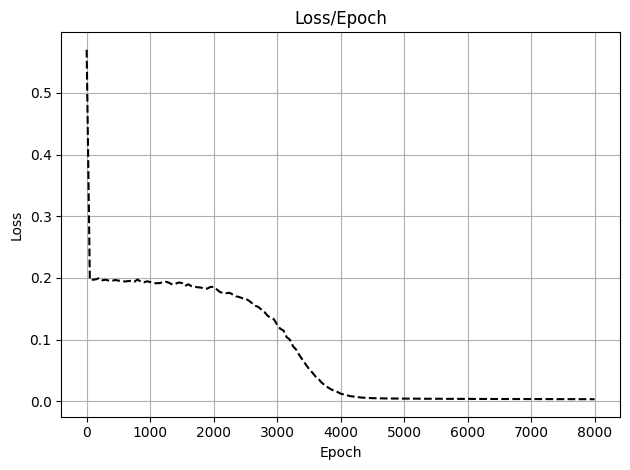

In [51]:
plot_loss(saved_loss)

<p class="task" id="4"></p>

4\. Повторите решение задач 1-2, используя для расчета значения функции потерь за эпоху метрику `MeanMetric` из пакета `torchmetrics`. Добавьте в цикл обучения расчет метрики $R^2$ (воспользуйтесь реализацией из `torchmetrics`). Выведите на экран график изменения значения функции потерь и метрики $R^2$ по эпохам в процессе обучения.

In [52]:
X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

In [53]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=20, shuffle=True)

In [54]:
def train_m(model, dataset, loader, n_epochs, criterion, optimizer, save_epochs, print_every=1000):
    saved_loss = {}
    saved_predictions = {}
    saved_r2 = {}
    for epoch in range(n_epochs):
        loss_arr = []
        r2_metric = M.R2Score()
        for X_batch, y_batch in loader:
            model.train()
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            loss_arr.append(loss.item())
            r2_metric.update(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch % 50 == 0:
            saved_loss[epoch] = np.mean(loss_arr)
            saved_r2[epoch] = r2_metric.compute().item()
        
        if epoch % print_every == 0:
            print(f'Epoch:{epoch:^6}| Loss: {np.mean(loss_arr):.4f} | R2: {r2_metric.compute().item():.4f}')
        
        if epoch in save_epochs:
            with th.no_grad():
                y_pred = model(dataset[:][0])
                saved_predictions[epoch] = y_pred.numpy().flatten()
    
    return saved_loss, saved_predictions, saved_r2

In [55]:
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [56]:
saved_loss, saved_predictions, saved_r2 = train_m(model, dataset, loader, 8001, criterion, optimizer, save_epochs)

Epoch:  0   | Loss: 0.5729 | R2: -0.1459
Epoch: 1000 | Loss: 0.0624 | R2: 0.8751
Epoch: 2000 | Loss: 0.0115 | R2: 0.9770
Epoch: 3000 | Loss: 0.0047 | R2: 0.9905
Epoch: 4000 | Loss: 0.0032 | R2: 0.9936
Epoch: 5000 | Loss: 0.0029 | R2: 0.9942
Epoch: 6000 | Loss: 0.0028 | R2: 0.9944
Epoch: 7000 | Loss: 0.0027 | R2: 0.9947
Epoch: 8000 | Loss: 0.0026 | R2: 0.9947


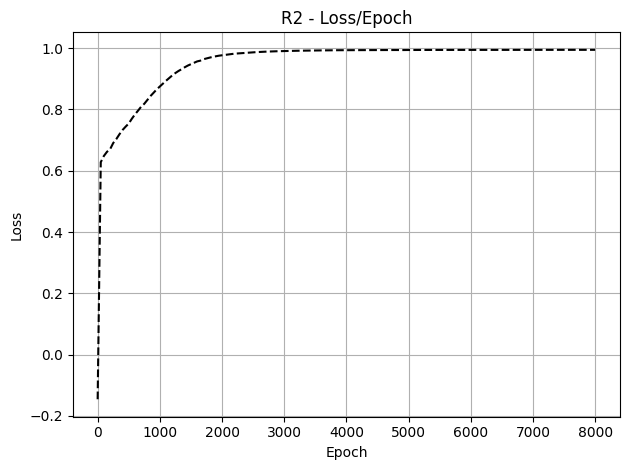

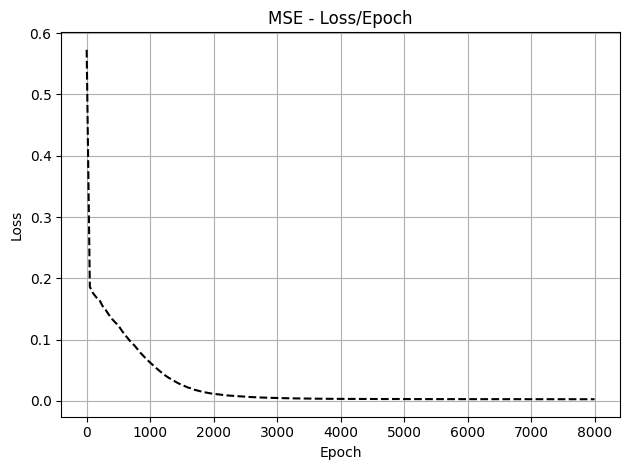

In [57]:
plot_loss(saved_r2, 'R2 - Loss/Epoch')
plot_loss(saved_loss, 'MSE - Loss/Epoch')

<p class="task" id="5"></p>

5\. Повторите решение задач 1-2, изменив функцию потерь. Обучите модель, используя три функции потерь: `MSELoss`, `L1Loss` и `HuberLoss` - и выведите на одном графике динамику изменения метрики $R^2$ по эпохам для каждой модели в процессе обучения. Добавьте подписи полученных кривых.

- [ ] Проверено на семинаре

Запуск с MSELoss:

Epoch:  0   | Loss: 0.5833 | R2: -0.1668
Epoch: 1000 | Loss: 0.0994 | R2: 0.8013
Epoch: 2000 | Loss: 0.0290 | R2: 0.9420
Epoch: 3000 | Loss: 0.0078 | R2: 0.9843
Epoch: 4000 | Loss: 0.0036 | R2: 0.9928
Epoch: 5000 | Loss: 0.0024 | R2: 0.9953
Epoch: 6000 | Loss: 0.0020 | R2: 0.9960
Epoch: 7000 | Loss: 0.0019 | R2: 0.9962
Epoch: 8000 | Loss: 0.0018 | R2: 0.9963


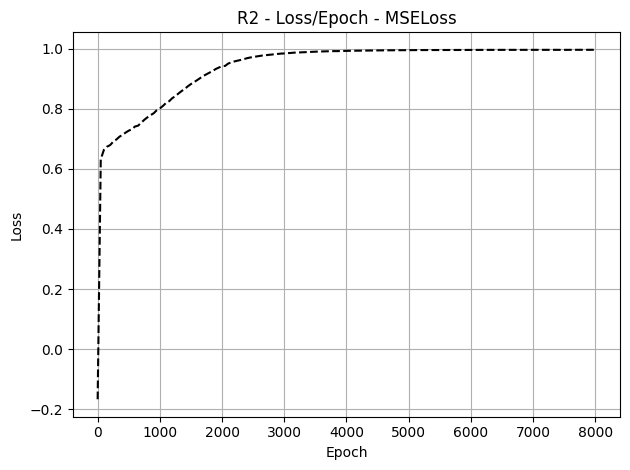


---------------------------------------------------------------------------

Запуск с L1Loss:

Epoch:  0   | Loss: 0.6495 | R2: -0.0417
Epoch: 1000 | Loss: 0.2097 | R2: 0.8427
Epoch: 2000 | Loss: 0.0501 | R2: 0.9925
Epoch: 3000 | Loss: 0.0338 | R2: 0.9962
Epoch: 4000 | Loss: 0.0344 | R2: 0.9964
Epoch: 5000 | Loss: 0.0456 | R2: 0.9935
Epoch: 6000 | Loss: 0.0356 | R2: 0.9961
Epoch: 7000 | Loss: 0.0428 | R2: 0.9941
Epoch: 8000 | Loss: 0.0330 | R2: 0.9966


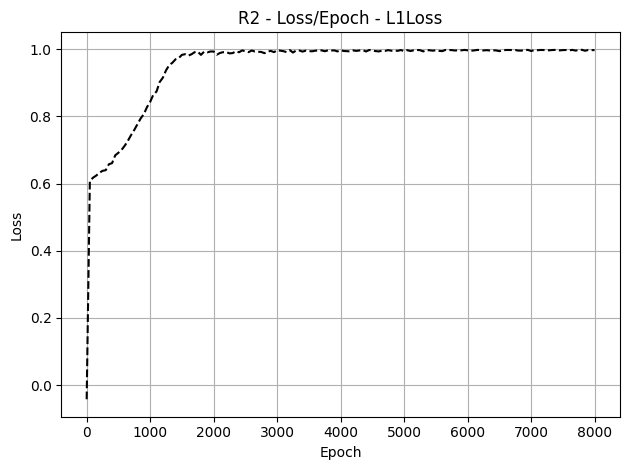


---------------------------------------------------------------------------

Запуск с HuberLoss:

Epoch:  0   | Loss: 0.2825 | R2: -0.1395
Epoch: 1000 | Loss: 0.0671 | R2: 0.7317
Epoch: 2000 | Loss: 0.0377 | R2: 0.8492
Epoch: 3000 | Loss: 0.0170 | R2: 0.9322
Epoch: 4000 | Loss: 0.0073 | R2: 0.9710
Epoch: 5000 | Loss: 0.0038 | R2: 0.9846
Epoch: 6000 | Loss: 0.0025 | R2: 0.9899
Epoch: 7000 | Loss: 0.0018 | R2: 0.9926
Epoch: 8000 | Loss: 0.0015 | R2: 0.9940


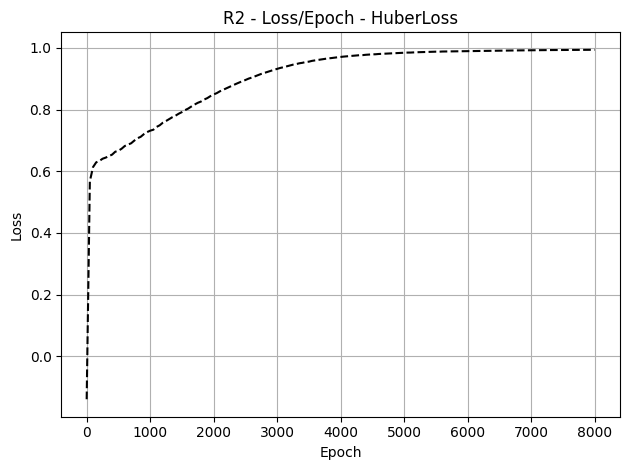


---------------------------------------------------------------------------



In [58]:
for loss in (nn.MSELoss, nn.L1Loss, nn.HuberLoss):
    model = nn.Sequential(
        nn.Linear(1, 50),
        nn.ReLU(),
        nn.Linear(50, 1),
    )
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = loss()

    print(f'Запуск с {loss.__name__}:\n')
    saved_loss, saved_predictions, saved_r2 = train_m(model, dataset, loader, 8001, criterion, optimizer, save_epochs)
    plot_loss(saved_r2, f'R2 - Loss/Epoch - {loss.__name__}')
    print('\n', '-'*75, '\n', sep='')

<p class="task" id="6"></p>

6\. Повторите решение задач 1-2, разделив датасет на обучающую и тестовую выборку в соотношении 80% на 20%. Обучите модель. Для тестовой выборки посчитайте и выведите на экран значения метрик:

- MAE;
- MAPE;
- MSE;
- MSLE;


- [ ] Проверено на семинаре

In [59]:
import torch.utils.data as data

In [60]:
X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

In [61]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=20, shuffle=True)
train_dataset, test_dataset = data.random_split(dataset, [0.8, 0.2])

In [62]:
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [63]:
saved_loss, saved_predictions, saved_r2 = train_m(model, dataset, loader, 8001, criterion, optimizer, save_epochs)

Epoch:  0   | Loss: 0.5172 | R2: -0.0476
Epoch: 1000 | Loss: 0.0714 | R2: 0.8553
Epoch: 2000 | Loss: 0.0133 | R2: 0.9730
Epoch: 3000 | Loss: 0.0053 | R2: 0.9892
Epoch: 4000 | Loss: 0.0034 | R2: 0.9931
Epoch: 5000 | Loss: 0.0029 | R2: 0.9941
Epoch: 6000 | Loss: 0.0028 | R2: 0.9944
Epoch: 7000 | Loss: 0.0027 | R2: 0.9946
Epoch: 8000 | Loss: 0.0026 | R2: 0.9947


In [64]:
y_pred = model(test_dataset[:][0])
print(' '+'_'*50)
for loss in (M.MeanAbsoluteError(), M.MeanAbsolutePercentageError(), M.MeanSquaredError(), M.MeanSquaredLogError()):
    print(f'| {loss.__class__.__name__:-^32}: {loss(y_pred, test_dataset[:][1]).item():-^14.4f} |')
print(' '+'‾'*50)

 __________________________________________________
| -------MeanAbsoluteError--------: ----0.0442---- |
| --MeanAbsolutePercentageError---: ----0.1900---- |
| --------MeanSquaredError--------: ----0.0030---- |
| ------MeanSquaredLogError-------: ----0.0064---- |
 ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
